**순환 신경망(Recurrent Neural Network, RNN)**  

- DFN의 시계열 데이터 처리의 한계점 해결하기 위한 신경망
- 유닛 간 연결이 순환적 구조를 이룸
- 신경망 내부에 상태를 저장할 수 있게 함으로써
- 내부의 메모리를 이용해 시퀀스 형태의 입력 처리
- 문자열, 센서 데이터, 음성인식과 같이 시간적으로 연속성이 있는 데이터 처리에 용이
- 층이 많은 네트워크에서 나타나는 그래디언트(기울기) 소실 문제(vanishing gradient problem) 발생
- 오랜 시간에 결쳐 학습시 gradient가 소실하는 문제

- 여러 개의 데이터가 순서대로 입력되었을 때 
    - 앞서 입력받은 데이터를 잠시 기억해 놓는 방법
    - 기억된 데이터가 얼마나 중요한지를 판단하여 
    - 별도의 가중치를 줘서 다음 데이터로 넘어감
- 모든 입력 값에 이 작업을 순서대로 실행하므로 
    - 다음 층으로 넘어가기 전에 같은 층을 맴도는 것처럼 보임


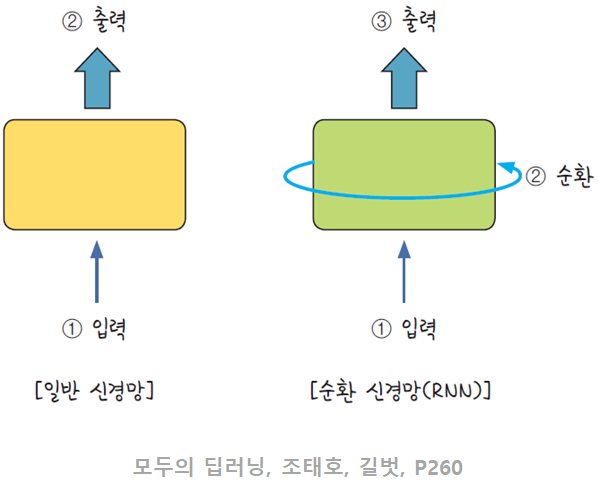

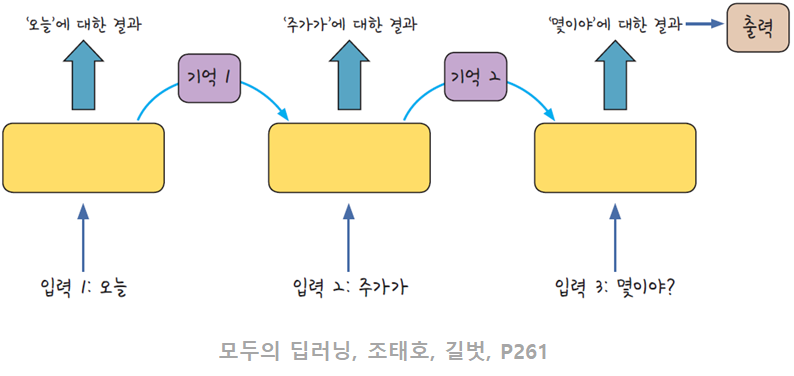

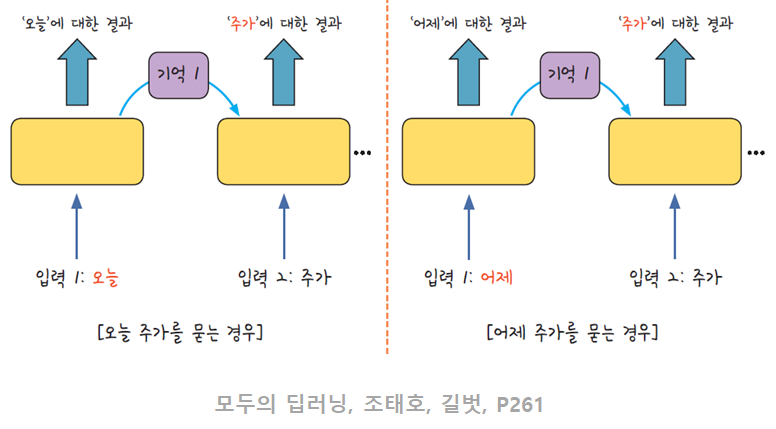

**케라스의 순환층**

In [1]:
from tensorflow.keras.layers import SimpleRNN

#### `SimpleRNN`
- 다른 케라스 층과 마찬가지로 시퀀스 배치를 처리
- `(batch_size, timesteps, input_features)` 크기의 입력을 받는다

- 케라스에 있는 모든 순환 층과 동일하게 `SimpleRNN`은 두 가지 모드로 실행가능
    - 각 타임스텝의 출력을 모은 전체 시퀀스를 반환 (크기가 `(batch_size, timesteps, output_features)`인 3D 텐서)
    - 입력 시퀀스에 대한 마지막 출력만 반환 (크기가 `(batch_size, output_features)`인 2D 텐서)
        - 이 모드는 객체를 생성할 때 `return_sequences` 매개변수로 선택할 수 있음

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN

In [4]:
#
model = Sequential()
model.add(Embedding(1000,32))
model.add(SimpleRNN(32))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 32)          32000     
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 32)                2080      
Total params: 34,080
Trainable params: 34,080
Non-trainable params: 0
_________________________________________________________________


In [6]:
model = Sequential()
model.add(Embedding(1000,32))
model.add(SimpleRNN(32, return_sequences=True))
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 32)          32000     
_________________________________________________________________
simple_rnn_3 (SimpleRNN)     (None, None, 32)          2080      
Total params: 34,080
Trainable params: 34,080
Non-trainable params: 0
_________________________________________________________________


- 네트워크의 표현력을 증가시키기 위해 여러 개의 순환 층을 차례대로 쌓는 것이 유용할 때가 있음
- **이런 설정**에서는 중간 층들이 전체 출력 시퀀스를 반환하도록 설정해야 함

In [7]:
model = Sequential()
model.add(Embedding(1000,32))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32, return_sequences=False)) # 맨 위층만 마지막 출력을
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 32)          32000     
_________________________________________________________________
simple_rnn_4 (SimpleRNN)     (None, None, 32)          2080      
_________________________________________________________________
simple_rnn_5 (SimpleRNN)     (None, None, 32)          2080      
_________________________________________________________________
simple_rnn_6 (SimpleRNN)     (None, 32)                2080      
Total params: 38,240
Trainable params: 38,240
Non-trainable params: 0
_________________________________________________________________


**IMDB 영화리뷰 문제에 RNN 적용**

**데이터전처리**

In [8]:
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing import sequence

max_features = 10000  # 특성으로 사용할 단어의 수
maxlen = 1000  # 사용할 텍스트의 길이(가장 빈번한 max_features 개의 단어만 사용합니다)
batch_size = 32

print('데이터 로딩...')
(input_train, y_train), (input_test, y_test) = imdb.load_data(num_words=max_features)
print(len(input_train), '훈련 시퀀스')
print(len(input_test), '테스트 시퀀스')

데이터 로딩...


<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
C:\Users\mkm05\anaconda3\lib\site-packages\tensorflow\python\keras\datasets\imdb.py:159: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])


25000 훈련 시퀀스
25000 테스트 시퀀스


C:\Users\mkm05\anaconda3\lib\site-packages\tensorflow\python\keras\datasets\imdb.py:160: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_test, y_test = np.array(xs[idx:]), np.array(labels[idx:])


**시퀀스패딩**

In [10]:
input_train = sequence.pad_sequences(input_train,maxlen=maxlen)
input_test =  sequence.pad_sequences(input_test,maxlen=maxlen)
print('input_train 크기:', input_train.shape)
print('input_test 크기:', input_test.shape)

input_train 크기: (25000, 1000)
input_test 크기: (25000, 1000)


In [12]:
from tensorflow.keras.layers import Dense

model = Sequential()
model.add(Embedding(max_features, 32))
model.add(SimpleRNN(32))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss= 'binary_crossentropy', metrics=['acc'])

history = model.fit(input_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

Epoch 1/10
157/157 [==============================] - 35s 218ms/step - loss: 0.6501 - acc: 0.6097 - val_loss: 0.5529 - val_acc: 0.7306
Epoch 2/10
157/157 [==============================] - 36s 229ms/step - loss: 0.3971 - acc: 0.8338 - val_loss: 0.3584 - val_acc: 0.8482
Epoch 3/10
157/157 [==============================] - 40s 256ms/step - loss: 0.2856 - acc: 0.8904 - val_loss: 0.4347 - val_acc: 0.8160
Epoch 4/10
157/157 [==============================] - 41s 260ms/step - loss: 0.2483 - acc: 0.9066 - val_loss: 0.3357 - val_acc: 0.8738
Epoch 5/10
157/157 [==============================] - 38s 242ms/step - loss: 0.1885 - acc: 0.9325 - val_loss: 0.4917 - val_acc: 0.8186
Epoch 6/10
157/157 [==============================] - 42s 271ms/step - loss: 0.1460 - acc: 0.9484 - val_loss: 0.4141 - val_acc: 0.8374
Epoch 7/10
157/157 [==============================] - 41s 260ms/step - loss: 0.0990 - acc: 0.9688 - val_loss: 0.4034 - val_acc: 0.8584
Epoch 8/10
157/157 [==============================] - 3

In [14]:
model.evaluate(input_test, y_test)

782/782 [==============================] - 23s 29ms/step - loss: 0.6402 - acc: 0.7914


[0.6402026414871216, 0.7913600206375122]

### 시각화

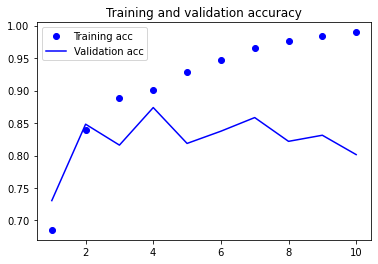

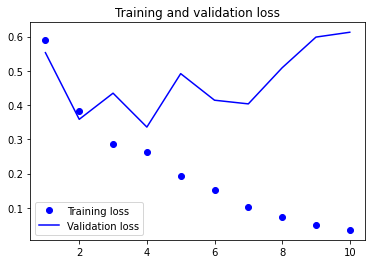

In [15]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### 결과

- 5_이진분류 예제에서 epoch 4번을 학습시켜 얻은 테스트 정확도는 88%
- 07_자연어처리 예제에서 epoch 10번을 학습시켜 얻은 학습 정확도는 88%  val_acc는 75% 정도 였음
- 간단한 순환 네트워크는 기준 모델(일찍 학습을 중단한)보다 성능이 높지 않다
- SimpleRNN은 텍스트와 같이 긴 시퀀스를 처리하는데는 적합하지 않다

### **Long Short-Term Memory (LSTM)**

- RNN에서 발생하는 그래디언트 소실 문제를 해결하기 위해 제안
- 한 층 안에서 반복을 많이 해야 하는 RNN의 특성상 
- 일반 신경망보다 기울기 소실 문제가 더 많이 살행하고
- 이를 보완하기 위한 방법
- 즉, 반복되기 직전에 다음 층으로 
- 기억된 값을 넘길지 안 넘길지를 관리하는 단계를 하나 더 추가


- 실전에서 응용들은 대부분 이 LSTM을 이용하여 구현
- forget gate, input gate, output gate라는 새로운 요소를 은닉층의 각 뉴런에 추가

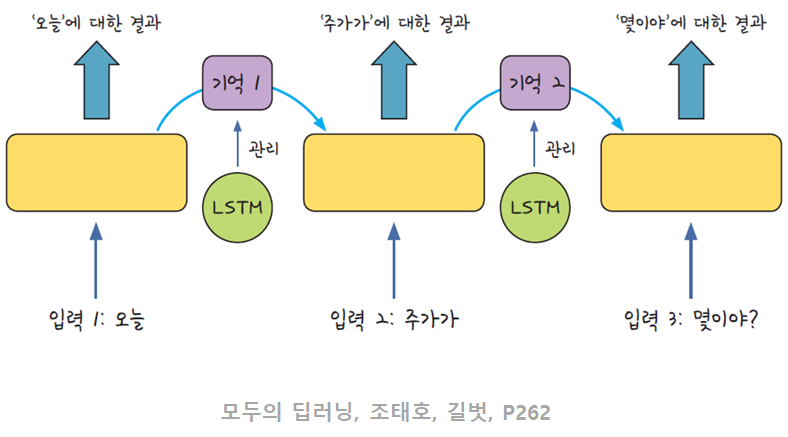

RNN(LSTM)의 장점  
- 입력 값과 출력 값을 어떻게 설정하느냐에 따라
- 여러 가지 상황에 적용할 수 있다는 것  
(1) 다수 입력 단일 출력  
(2) 단일 입력 다수 출력  
(3) 다수 입력 다수 출력  

In [17]:
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense

model = Sequential()
model.add(Embedding(max_features, 32))
model.add(LSTM(32))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss= 'binary_crossentropy', metrics=['acc'])

history = model.fit(input_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

Epoch 1/10
157/157 [==============================] - 79s 495ms/step - loss: 0.6225 - acc: 0.6614 - val_loss: 0.4039 - val_acc: 0.8204
Epoch 2/10
157/157 [==============================] - 87s 552ms/step - loss: 0.3101 - acc: 0.8752 - val_loss: 0.3853 - val_acc: 0.8278
Epoch 3/10
157/157 [==============================] - 79s 504ms/step - loss: 0.2295 - acc: 0.9150 - val_loss: 0.4909 - val_acc: 0.8018
Epoch 4/10
157/157 [==============================] - 78s 494ms/step - loss: 0.2037 - acc: 0.9264 - val_loss: 0.2921 - val_acc: 0.8816
Epoch 5/10
157/157 [==============================] - 79s 506ms/step - loss: 0.1736 - acc: 0.9376 - val_loss: 0.2987 - val_acc: 0.8786
Epoch 6/10
157/157 [==============================] - 80s 512ms/step - loss: 0.1554 - acc: 0.9452 - val_loss: 0.3314 - val_acc: 0.8768
Epoch 7/10
157/157 [==============================] - 80s 506ms/step - loss: 0.1352 - acc: 0.9541 - val_loss: 0.3693 - val_acc: 0.8672
Epoch 8/10
157/157 [==============================] - 7

In [18]:
model.evaluate(input_test, y_test)

782/782 [==============================] - 40s 51ms/step - loss: 0.3752 - acc: 0.8595


[0.3751651644706726, 0.8594800233840942]

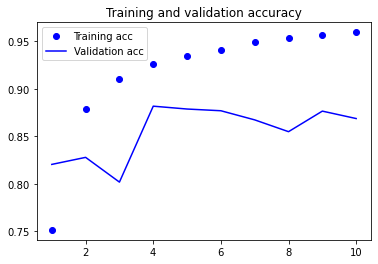

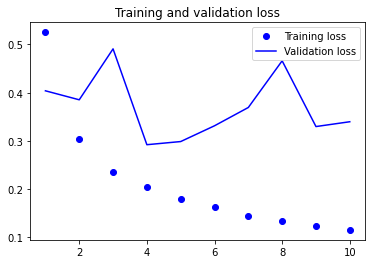

In [19]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### SimpleRnn과 비교 
- SimpleRnn이 75%의 예측
- LSTM 85% 의 예측
- 그래프상 loss의 굴곡이 있지만 내려가는 추세기 때문에 epoch를 증가시키면 성능 향상을 볼 수 있음